## Direct Marketing Effectiveness: A Logistic Regression Approach

**This example demonstrates the implementation of logistic regression to predict whether a client will subscribe to a term deposit based on the
outcomes of direct marketing campaigns (via phone calls).**

**Logistic regression is a classification algorithm.<br> It predicts the likelihood of a categorical outcome (like binary decisions: yes/no, 0/1).<br> Specifically, it estimates the probability 𝑃(𝑌=1) given the input variables 𝑋.** <br>
**For instance, in our banking example, it calculates the probability that a client will subscribe to a term deposit (1) or not (0)**

**Assumptions in Logistic Regression**<br>
**No Multicollinearity**: The independent variables (predictors) should not be highly correlated with each other.<br>
**Linear Relationship to Log Odds**: The independent variables should have a linear relationship with the log odds of the outcome.<br>
**Large Sample Size**: Logistic regression works best with large datasets to ensure reliable and stable predictions.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
data = pd.read_csv(r"C:\Users\Dell\Downloads\banking.csv",header=0)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [3]:
# Dropping the null values
data = data.dropna() 

In [4]:
data.shape

(41188, 21)

In [5]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

**Understanding the Data**

1. **age** (numeric)<br>
2. **job**: type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)<br>
3. **marital**: marital status (categorical: “divorced”, “married”, “single”, “unknown”)<br>
4. **education** (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)<br>
5. **default**: has credit in default? (categorical: “no”, “yes”, “unknown”)<br>
6. **housing**: has housing loan? (categorical: “no”, “yes”, “unknown”)<br>
7. **loan**: has personal loan? (categorical: “no”, “yes”, “unknown”)<br>
8. **contact**: contact communication type (categorical: “cellular”, “telephone”)<br>
9. **month**: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)<br>
10. **day_of_week**: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)<br>
11. **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model<br>
12. **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13. **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14. **previous**: number of contacts performed before this campaign and for this client (numeric)<br>
15. **poutcome**: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)<br>
16. **emp.var.rate**: employment variation rate — (numeric)<br>
17. **cons.price.idx**: consumer price index — (numeric)<br>
18. **cons.conf.idx**: consumer confidence index — (numeric)<br>
19. **euribor3m**: euribor 3 month rate — (numeric)<br>
20. **nr.employed**: number of employees — (numeric)<br>


**Target Variable**<br>
y — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)

**Bucketing** is the process of grouping multiple categories into fewer, broader ones to simplify data for modeling.<br> **For example**, in the education column, instead of handling categories like "basic.4y," "basic.6y," "university.degree," etc., you could combine them into buckets like "basic," "higher education," and "unknown." <br>This helps reduce complexity and improves model performance.<br>

**Bucketing : Education**<br>
Education has many categories. We are going to reduce it for better modeling.

In [6]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

In [7]:
## Grouping basic - 4,6 and 9 years into basic

data['education']=np.where(data['education']=='basic.9y','Basic',data['education'])
data['education']=np.where(data['education']=='basic.6y','Basic',data['education'])
data['education']=np.where(data['education']=='basic.4y','Basic',data['education'])

In [8]:
## Checking the education field again

data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

In [9]:
# Understanding the Target variable first

data['y'].value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

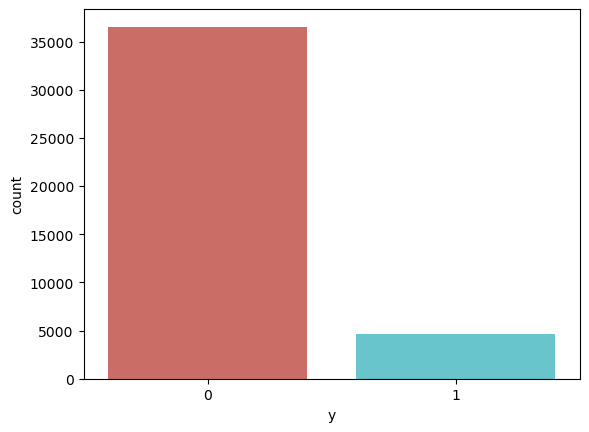

In [14]:
# Visualizing

# Countplot is a type of bar plot in Seaborn that displays the frequency of categorical variables.
sns.countplot(x='y', data=data, hue='y', palette='hls', legend=False)
plt.show()
# plt.savefig('count_plot')

In [15]:
# By looking at th graph, we can understand that, we have 36548 cases of 'no success', and '4640' cases of success.

In [ ]:
# understanding how the mean values are, for both the classes.

data.groupby('y').mean()

TypeError: agg function failed [how->mean,dtype->object]